# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [30]:
import pickle
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import sklearn

---
## Step 0: Load The Data

In [4]:
from trscripts.datasets import german_traffic_signs
germanTrafficSign = german_traffic_signs.GermanTrafficSigns()
germanTrafficSign.download()

File was already downloaded


In [5]:
germanTrafficSign.extract()

/Users/nixoxo/Code/Self_Driving_Cars/Term_1/CarND-Traffic-Sign-Classifier-Project/trscripts/data/german_traffic_signs already present - Skipping extraction of downloaded zip.


In [6]:
X_train, y_train, X_test, y_test = germanTrafficSign.get_data()
X = X_test
y = y_test

In [7]:
# Shuffle
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [9]:
# test / valid split
from sklearn.model_selection import train_test_split
X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.5, random_state=42)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [10]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_valid = X_valid.shape[0]
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 6315
Number of validation examples = 6315
Image data shape = (32, 32, 3)
Number of classes = 43


In [11]:
path = "signnames.csv"

def read_signs():
    with open(path, 'r') as signs_file:
        lines = signs_file.readlines()
        lines = lines[1:]
        signs={}
        for line in lines:
            splitted_line = line.split(",")
            class_id = splitted_line[0]
            sign_name = splitted_line[1].replace('\n', '')
            signs[class_id] = sign_name
            
        return signs

signs = read_signs()

def get_sign(class_id):
    return signs[str(class_id)]

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

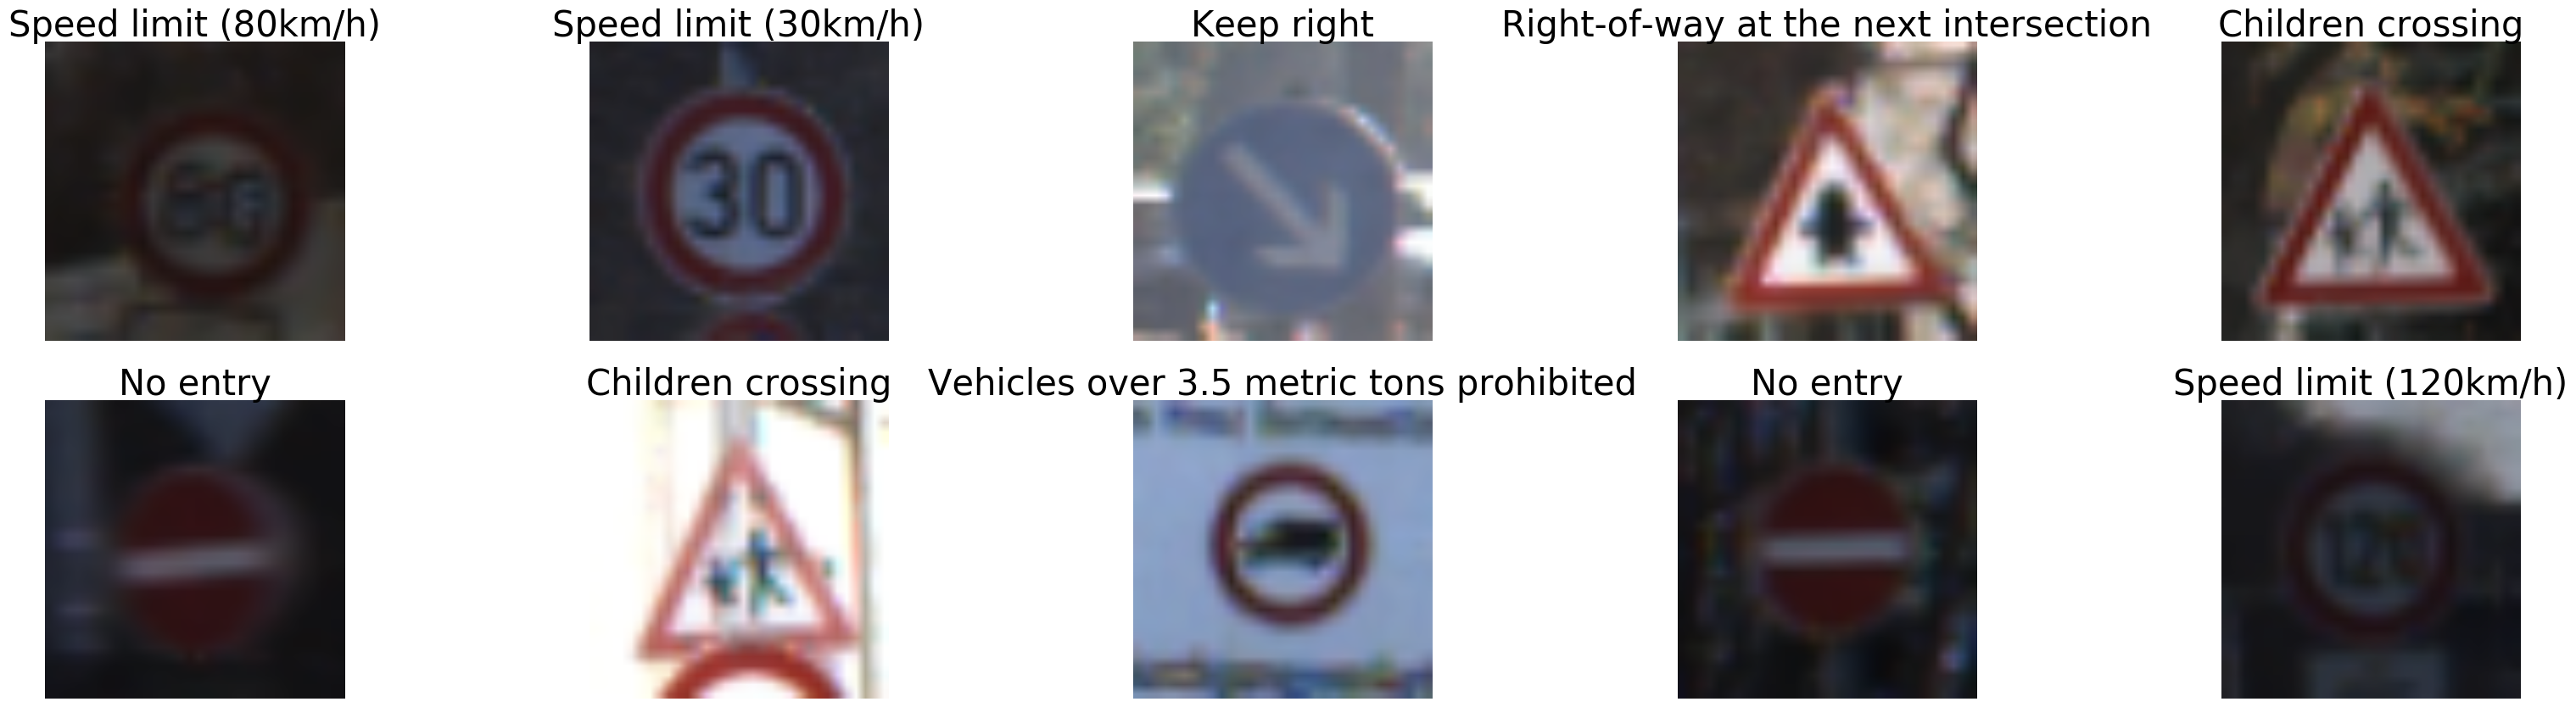

In [12]:
%matplotlib inline
figure, axes = plt.subplots(nrows=2, ncols=5)
figure.set_figheight(10)
figure.set_figwidth(40)
for row in range(2):
    for column in range(5):
        index = random.randrange(0, n_train, 2)
        axes[row][column].axis('off')
        class_id = y_train[index]
        axes[row][column].set_title(get_sign(class_id), fontsize=30)
        axes[row][column].imshow(X_train[index])

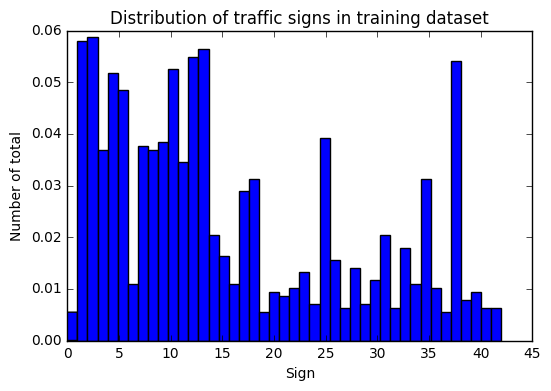

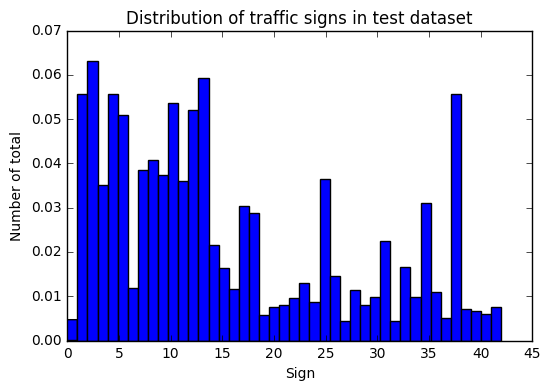

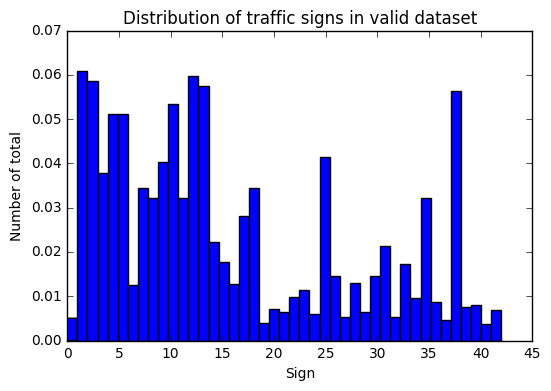

In [13]:
plt.title("Distribution of traffic signs in training dataset")
plt.xlabel("Sign")
plt.ylabel("Number of total")
plt.hist(y_train, bins=n_classes, normed=True)
plt.show()

plt.title("Distribution of traffic signs in test dataset")
plt.xlabel("Sign")
plt.ylabel("Number of total")
plt.hist(y_test, bins=n_classes, normed=True)
plt.show()

plt.title("Distribution of traffic signs in valid dataset")
plt.xlabel("Sign")
plt.ylabel("Number of total")
plt.hist(y_valid, bins=n_classes, normed=True)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [14]:
# We need to transform the data into another datatype to allow below zero values
X_train = X_train.astype(np.int16)
X_test = X_test.astype(np.int16)
X_valid = X_valid.astype(np.int16)

In [43]:
def normalization(data):
    return (data-128)/128

X_train = normalization(X_train)
X_test = normalization(X_test)
X_valid = normalization(X_valid)

In [16]:
def create_data_label(X, y):
    return {
        'data':X,
        'label':y
    }

preprocess_file = 'tensorflow_data.pickle'

try:
    with open(preprocess_file, 'wb') as file:
        dump = {
            'train': create_data_label(X_train, y_train),
            'test': create_data_label(X_test, y_test),
            'valid':create_data_label(X_valid, y_valid)
        }
        pickle.dump(dump, file)
except Exception as e:
    print('Unable to save data to', tensorflow_file, ':', e)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** I preprocessed the data by normalizing it. This is done by subtracting 128 of the pixel and then dividing it by 128. A pixel with a value 0 before normalizing has now the value -1 and a value of 255 has now the value of ~1.

After normalizing the data, the processed data is well conditioned. This means that the mean of the data is zero and the variance is equal across the data. These are perfect conditions for applying deep learning.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** The corpus consists of 51839 samples. I shuffled the train and test data to get a more random occurrence of the traffic signs. In the next step I decided to split the test samples into equal parts for a validation set and a testing set. The whole corpus is split into **75/12.5/12.5**. 

* Training samples: 39209 (~75%)
* Valididation samples: 6315 (~12.5%)
* Testing samples: 6315 (~12.5%)

In [51]:
EPOCHS = 20
BATCH_SIZE = 256
n_classes = 43
patch_size = 5
depth_1 = 32
depth_2 = 64
depth_3 = 128
depth_4 = 256

In [54]:
from tensorflow.contrib.layers import flatten

def model(x):    
    
    weights = {
        'conv1': tf.Variable(tf.random_normal(shape=(patch_size, patch_size, 3, depth_1))),
        'conv2': tf.Variable(tf.random_normal(shape=(patch_size, patch_size, depth_1, depth_2))),
        'conv3': tf.Variable(tf.random_normal(shape=(patch_size, patch_size, depth_2, depth_3))),
        'conv4': tf.Variable(tf.random_normal(shape=(patch_size, patch_size, depth_3, depth_4))),
        'fc1': tf.Variable(tf.random_normal(shape=(65536, 5120))),
        'fc2': tf.Variable(tf.random_normal(shape=(5120, 84))),
        'fc3': tf.Variable(tf.random_normal(shape=(84, n_classes)))
    }
    
    biases = {
        'conv1': tf.Variable(tf.zeros(depth_1)),
        'conv2': tf.Variable(tf.zeros(depth_2)),
        'conv3' : tf.Variable(tf.zeros(depth_3)),
        'conv4' : tf.Variable(tf.zeros(depth_4)),
        'fc1': tf.Variable(tf.zeros(5120)),
        'fc2': tf.Variable(tf.zeros(84)),
        'fc3': tf.Variable(tf.zeros(n_classes))
    }
    
    def conv2d(x, W, b, strides=[1, 1, 1, 1], padding='VALID'):
        conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding=padding)
        conv = tf.nn.bias_add(conv, b)
        return tf.nn.relu(conv)
    
    
    def max_pool2d(x, ksize=[1, 1, 1, 1], strides= [1, 1, 1, 1], padding='VALID'):
        return tf.nn.max_pool(x, ksize=ksize, strides=strides, padding=padding)
   
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x8.
    conv1 = conv2d(x, weights['conv1'], biases['conv1'])
    conv1 = max_pool2d(conv1)
    
    print(conv1)

    # SOLUTION: Layer 2: Convolutional. Input: 28x28x16 Output = 24x24x16.
    conv2 = conv2d(conv1, weights['conv2'], biases['conv2'])
    conv2 = max_pool2d(conv2)
    print(conv2)
    
    
    # Layer 1: Convolutional. Input = 24x24x16. Output = 20x20x32.
    conv3 = conv2d(conv2, weights['conv3'], biases['conv3'])
    conv3 = max_pool2d(conv3)
    print(conv3)
    
    conv4 = conv2d(conv3, weights['conv4'], biases['conv4'])
    conv4 = max_pool2d(conv4)
    print(conv4)

    # SOLUTION: Flatten. Input = 20x20x32. Output = 12800.
    fc0   = flatten(conv4)
    print(fc0)
    
    def fully_connected(x, W, b):
        return tf.add(tf.matmul(x, W), b)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 12800. Output = 1000.
    fc1 = fully_connected(fc0, weights['fc1'], biases['fc1'])
    fc1 = tf.nn.relu(fc1)
    print(fc1)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84
    fc2 = fully_connected(fc1, weights['fc2'], biases['fc2'])
    fc2 = tf.nn.relu(fc2)
    print(fc2)
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = fully_connected(fc2, weights['fc3'], biases['fc3'])
    print(logits)
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
logits = model(x)

Tensor("MaxPool_30:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool_31:0", shape=(?, 24, 24, 64), dtype=float32)
Tensor("MaxPool_32:0", shape=(?, 20, 20, 128), dtype=float32)
Tensor("MaxPool_33:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("Flatten_10/Reshape:0", shape=(?, 65536), dtype=float32)
Tensor("Relu_53:0", shape=(?, 5120), dtype=float32)
Tensor("Relu_54:0", shape=(?, 84), dtype=float32)
Tensor("Add_20:0", shape=(?, 43), dtype=float32)


In [55]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [57]:
rate = 0.001

logits = model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Tensor("MaxPool_36:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool_37:0", shape=(?, 24, 24, 64), dtype=float32)
Tensor("MaxPool_38:0", shape=(?, 20, 20, 128), dtype=float32)
Tensor("MaxPool_39:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("Flatten_11/Reshape:0", shape=(?, 65536), dtype=float32)
Tensor("Relu_61:0", shape=(?, 5120), dtype=float32)
Tensor("Relu_62:0", shape=(?, 84), dtype=float32)
Tensor("Add_23:0", shape=(?, 43), dtype=float32)


In [87]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [88]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.893

EPOCH 2 ...
Validation Accuracy = 0.919

EPOCH 3 ...
Validation Accuracy = 0.915

EPOCH 4 ...
Validation Accuracy = 0.923

EPOCH 5 ...
Validation Accuracy = 0.923

EPOCH 6 ...
Validation Accuracy = 0.919

EPOCH 7 ...
Validation Accuracy = 0.937

EPOCH 8 ...
Validation Accuracy = 0.937



KeyboardInterrupt: 

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.